In [1]:
import requests
import pandas as pd
import math
import numpy as np
import requests
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt

In [2]:
reload = False
COMMUNES_FILES = 'data/communes-martinique.geojson'
gdf = gpd.read_file(COMMUNES_FILES)
bounds = gdf.bounds
lon_min, lon_max, lat_min, lat_max = bounds['minx'].min(), bounds['maxx'].max(), bounds['miny'].min(), bounds['maxy'].max()

In [3]:
def get_address(num, type_voie, nom_voie, cp, commune):
    address = ""
    if not math.isnan(num):
        address = f'{int(num)}, '
    
    sep = ''
    if not pd.isnull(type_voie):
        address += f'{type_voie}'
        sep = ' '
    
    if not pd.isnull(nom_voie):
        address += f'{sep}{nom_voie}'
    
    address = f'{address}, {cp} {commune}'
    return address

def api_lat_lon_score(address):
    r = requests.get("https://api-adresse.data.gouv.fr/search/", params={"q": address, "limit": 1})
    lon, lat, score = None, None, None
    if r.status_code == 200:   
        response = r.json()
        if 'features' in response and len(response['features']) > 0:
            feature = response['features'][0]
            if "geometry" in feature and "coordinates" in feature['geometry']:
                lon, lat = feature['geometry']['coordinates']
            if "properties" in feature and "score" in feature['properties']:
                score = response['features'][0]['properties']['score']
    return pd.Series([lon, lat, score])

if reload:
    !curl https://files.data.gouv.fr/insee-sirene/StockEtablissement_utf8.zip -o data-tmp/StockEtablissement_utf8.zip
    !unzip data-tmp/StockEtablissement_utf8.zip -d data-tmp/
    !head -1 data-tmp/StockEtablissement_utf8.csv > data/sirene-mq-alimentation.csv
    !fgrep ,972 data-tmp/StockEtablissement_utf8.csv|grep -P ",56[^,]+,NAF" >> data/sirene-mq-alimentation.csv
    
    df = pd.read_csv('data/sirene-mq-alimentation.csv')
    # filter wrongly included values
    df = df.loc[df.codePostalEtablissement.astype(str).str.startswith('972')]
    # only keep opened companies
    df_open = df.loc[df.etatAdministratifEtablissement == 'A'].copy().reset_index(drop=True)

    # create nice address
    df_open['addresse'] = df_open[[
        'numeroVoieEtablissement', 
        'typeVoieEtablissement',
        'libelleVoieEtablissement',
        'codePostalEtablissement', 
        'libelleCommuneEtablissement'
    ]].apply(lambda x: get_address(x['numeroVoieEtablissement'], x['typeVoieEtablissement'], x['libelleVoieEtablissement'], x['codePostalEtablissement'], x['libelleCommuneEtablissement']), axis=1)

    # this takes time (30 - 45 minutes) but we play nice with API server
    df_open[['lon', 'lat', 'score']] = df_open.apply(lambda x: api_lat_lon_score(x['addresse']), axis=1)
    df_open.to_csv('data/sirene-mq-alimentation-with-geoloc.csv', index=False)
else:
    df_open = pd.read_csv('data/sirene-mq-alimentation-with-geoloc.csv')

In [4]:
df_ok = df_open[['addresse', 'lon', 'lat', 'score',  'nomenclatureActivitePrincipaleEtablissement']].dropna()
df_ok = df_ok.loc[(df_ok.lat > lat_min) & (df_ok.lat < lat_max) & (df_ok.lon > lon_min) & (df_ok.lon < lon_max)]

gdf_resto = gpd.GeoDataFrame(df_ok)
gdf_resto['geometry'] = gdf_resto.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
gdf_resto = gdf_resto.set_crs('EPSG:4326')

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


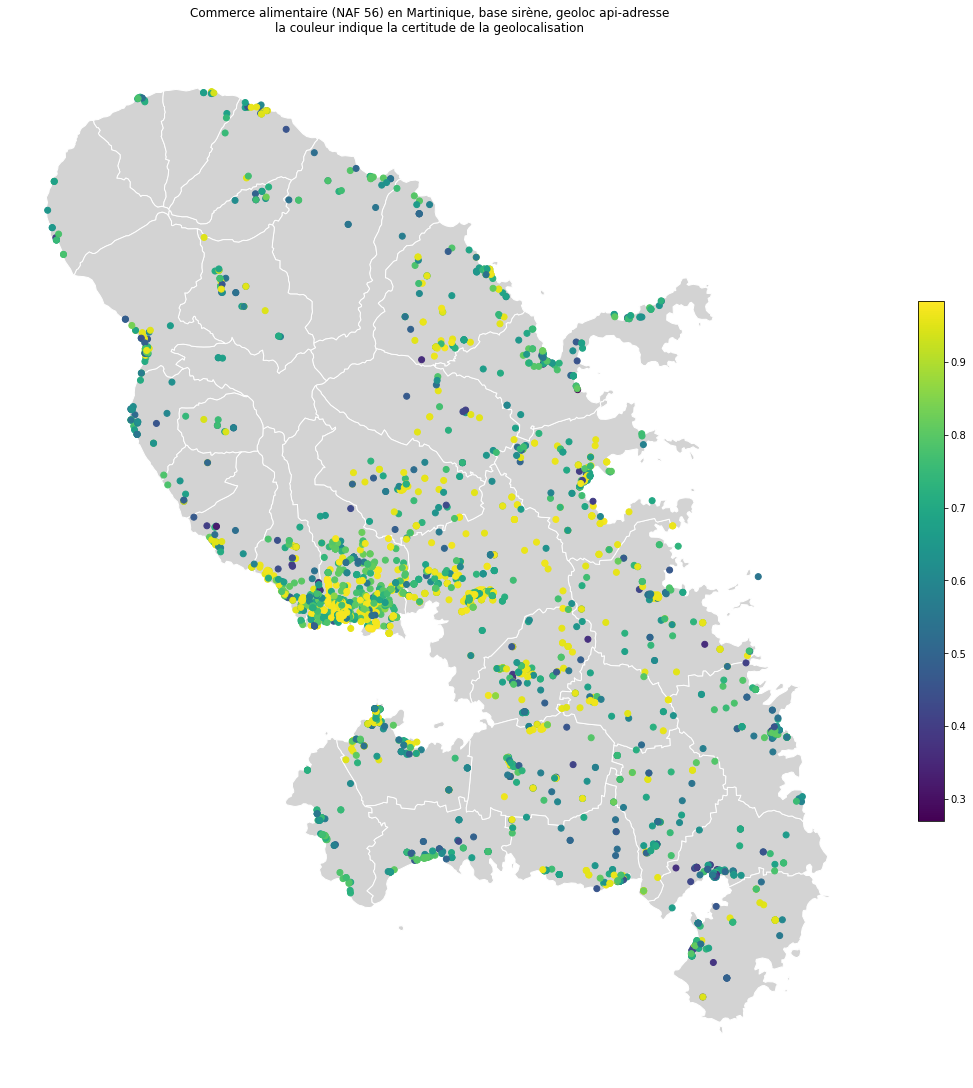

In [5]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 15))
fig.suptitle("Commerce alimentaire (NAF 56) en Martinique, base sirène, geoloc api-adresse\nla couleur indique la certitude de la geolocalisation",
             backgroundcolor='white', color='black')

gdf.plot(ax=ax, color='lightgray', edgecolor='white')
gdf_resto.plot(ax=ax, column='score', legend=True, legend_kwds={"shrink":0.5})
_ = ax.axis('off')

plt.savefig('output/2022-11-15.png', facecolor='white')